In [1]:
%load_ext autoreload
%autoreload 2
import jax
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
import gzip
import pathlib
import pickle
from itertools import product

import jax.numpy as jnp
import numpy as np
import utils
from ptarcade import chains_utils as cu
from ptarcade import models_utils as mu

In [2]:
from models import dw_ds, dw_sm, pt_bubble, pt_sound, sigw_box, sigw_delta, sigw_gauss

model_dict = {
    "PT Sound": {
        "model": pt_sound,
        "l_bounds": jnp.array([-2, -4, -3, 3, 2, 3]),
        "u_bounds": jnp.array([1, 4, 0, 5, 4, 5]),
        "l_bounds_post": jnp.array([-0.18, -2.06, -1.00, 3, 2, 3.85]),
        "u_bounds_post": jnp.array([0.70, -1.30, -0.38, 3.74, 3.17, 5]),
        "map": jnp.array([-0.01, -1.75, -0.82, 3, 2, 5]),
        "model_params": ["log10_alpha", "log10_T_star", "log10_H_R", "a", "b", "c"],
    },
    "PT Bubble": {
        "model": pt_bubble,
        "l_bounds": jnp.array([-2, -4, -3, 1, 1, 1]),
        "u_bounds": jnp.array([1, 4, 0, 3, 3, 3]),
        "l_bounds_post": jnp.array([0.03, -1.33, -0.56, 1.49, 1, 1.69]),
        "u_bounds_post": jnp.array([1, -0.39, 0, 2.54, 2.32, 3]),
        "map": jnp.array([1, -0.90, 0, 1.97, 1, 3]),
        "model_params": ["log10_alpha", "log10_T_star", "log10_H_R", "a", "b", "c"],
    },
    "DW Dark Radiation": {
        "model": dw_ds,
        "l_bounds": jnp.array([-3, -4, 0.5, 0.3]),
        "u_bounds": jnp.array([jnp.log10(0.39), 4, 1, 3]),
        "l_bounds_post": jnp.array([-0.49, -1.10, 0.5, 1.62]),
        "u_bounds_post": jnp.array([-0.41, -0.82, 0.97, 3]),
        "map": jnp.array([-0.41, -0.94, 0.5, 3]),
        "model_params": ["log10_N_eff", "log10_T_star", "b", "c"],
    },
    "DW SM Decay": {
        "model": dw_sm,
        "l_bounds": jnp.array([-3, -4, 0.5, 0.3]),
        "u_bounds": jnp.array([0, 4, 1, 3]),
        "l_bounds_post": jnp.array([-1.10, -0.96, 0.5, 1.72]),
        "u_bounds_post": jnp.array([-0.71, -0.56, 0.83, 3]),
        "map": jnp.array([-0.92, -0.79, 0.5, 3]),
        "model_params": ["log10_alpha", "log10_T_star", "b", "c"],
    },
    "SIGW Gauss": {
        "model": sigw_gauss,
        "l_bounds": jnp.array([-3, -11, 0.1]),
        "u_bounds": jnp.array([1, -5, 3]),
        "l_bounds_post": jnp.array([-1.03, -7.25, 0.51]),
        "u_bounds_post": jnp.array([0.20, -5.65, 2.07]),
        "map": jnp.array([-0.34, -7.03, 2.60]),
        "model_params": ["log10_A", "log10_fpeak", "width"],
    },
    "SIGW Box": {
        "model": sigw_box,
        "l_bounds": jnp.array([-3, -11, -11]),
        "u_bounds": jnp.array([1, -5, -5]),
        "l_bounds_post": jnp.array([-1.72, -6.42, -8.01]),
        "u_bounds_post": jnp.array([-0.82, -5, -6.97]),
        "map": jnp.array([-1.26, -5.40, -7.50]),
        "model_params": ["log10_A", "log10_fmax", "log10_fmin"],
    },
    "SIGW Delta": {
        "model": sigw_delta,
        "l_bounds": jnp.array([-3, -11]),
        "u_bounds": jnp.array([1, -5]),
        "l_bounds_post": jnp.array([-1.00, -6.17]),
        "u_bounds_post": jnp.array([-0.01, -5]),
        "map": jnp.array([-0.14, -5]),
        "model_params": ["log10_A", "log10_f_peak"],
    },
}

n = 96721  # Number of draws, has to be prime
# Set frequency space. Most of the interpolated models in the 15yr only go up
# to 10**-5 Hz, be aware that this affects integrated energy densities (Neff),
# but it doesn't impact the rule of thumb calculations.
freqs = jnp.logspace(-10, 2, 1000)

In [3]:
results = []
results_post = []

for _, model in enumerate(model_dict):
    print(model)

    sub_dict = model_dict[model]
    func = utils.create_vmap_function(sub_dict["model"].spectrum, freqs)

    d = (
        len(sub_dict["l_bounds"])
        if (len(sub_dict["l_bounds"]) == len(sub_dict["u_bounds"]))
        else None
    )
    if not d:
        raise Exception(f"{len(sub_dict['l_bounds'])=} != {len(sub_dict['u_bounds'])=}")

    sampler = utils.create_sampler(d)
    samples = jnp.array(
        utils.get_samples(sampler, n, sub_dict["l_bounds"], sub_dict["u_bounds"])
    )

    results.append(func(samples))

    samples = jnp.array(
        utils.get_samples(
            sampler, n, sub_dict["l_bounds_post"], sub_dict["u_bounds_post"]
        )
    )

    # Add samples at the edges.
    samples = jnp.vstack(
        (
            samples,
            jnp.array(
                list(
                    product(*zip(sub_dict["l_bounds_post"], sub_dict["u_bounds_post"]))
                )
            ),
        )
    )

    results_post.append(func(samples))

PT Sound
PT Bubble
DW Dark Radiation
DW SM Decay
SIGW Gauss
SIGW Box
SIGW Delta


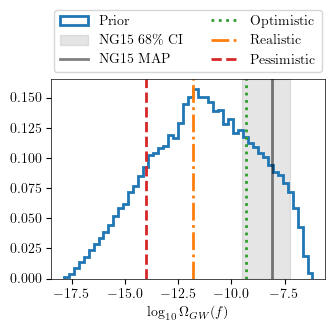

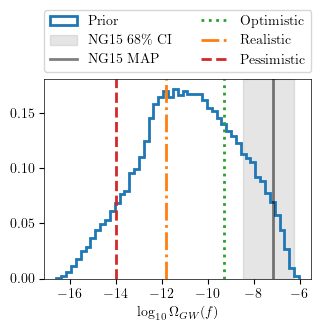

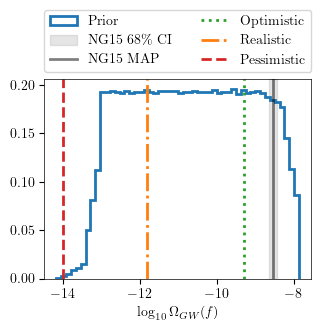

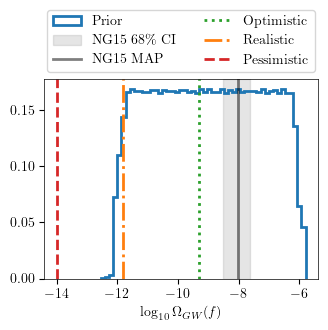

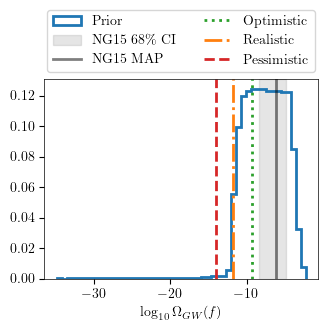

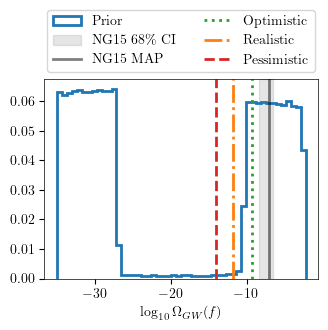

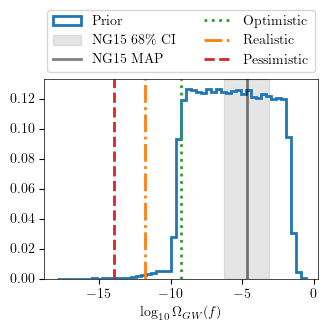

In [4]:
plt.rcParams.update(
    {
        "axes.linewidth": 0.5,
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cm",
    }
)
for i, model in enumerate(model_dict):
    fig, ax = utils.plot_peak_omega_gw_hist(
        results[i], model, labels=["Prior"], save=False
    )

    min_peak, mean_peak, max_peak = jnp.log10(
        jnp.array(
            [results_post[i].min(), results_post[i].mean(), results_post[i].max()]
        )
    )

    ax.axvspan(min_peak, max_peak, alpha=0.2, color="grey", label="NG15 68\% CI")
    ax.axvline(mean_peak, color="black", alpha=0.5, label="NG15 MAP", linewidth=2)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, -2, -1, 1, 2, 3]
    ax.legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        bbox_to_anchor=(0.5, 1.00),
        loc="lower center",
        ncol=2,
    )
    fig.tight_layout()

    fig_dir = pathlib.Path().cwd() / "figs"
    fig_dir.mkdir(exist_ok=True)
    fig.savefig(
        fig_dir / f"{model.replace(' ','-').lower()}-peak-omega-hist.pdf",
        bbox_inches="tight",
    )